In [1]:
import pandas as pd
import numpy as np

In [6]:
train_raw = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None)
train_raw.columns = ['text', 'label']

In [7]:
train_raw.head()

,text,label
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


Видно, что тексты отзывов содержат много лишних символов: цифр, знаков препинания, пробелов. Предобработаем отзывы: обрежем лишние пробелы и приведём все буквы к нижнему регистру.

Также уберём знаки препинания: для этого воспользуемся методом `translate`, который по заданному словарю переводит строку. Нужный нам словарь будет переводить все знаки препинания в `None`.

Далее лемматизируем слова в полученных строках.

In [56]:
from nltk import WordNetLemmatizer

punctuation = dict.fromkeys("!?#$%^&*()'\"~.")  # словарь для удаления знаков препинания

def replace_digits(s: str) -> str:
    for i in range(10):
        s = s.replace(str(i), '')
    return s

def process(s: str) -> str:
    s = replace_digits(s.strip().lower().replace(" '", "").translate(punctuation))
    lm = WordNetLemmatizer()
    return " ".join([lm.lemmatize(word) for word in s.split()])

Попробуем какую-нибудь простую модель для классификации:

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [57]:
train_lemmatized = train_raw.text.apply(process)

In [66]:
model_0 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [59]:
cv_0 = cross_val_score(model_0, train_lemmatized, train_raw.label, cv=3).mean()
cv_0

0.7720021370696033

Попробуем найти модель с б**о**льшим качеством на кросс-валидации.

### 1. `CountVectorizer` с n-граммами

In [36]:
def evaluate_model(vectorizer=CountVectorizer(), classifier=LogisticRegression(solver='liblinear')) -> float:
    model = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])
    return cross_val_score(model, train_lemmatized, train_raw.label, cv=3).mean()

In [38]:
evaluate_model(vectorizer=CountVectorizer(ngram_range=(1, 2)))

0.7705043874459166

In [39]:
evaluate_model(vectorizer=CountVectorizer(ngram_range=(1, 3)))

0.7700031365698532

Видно, что качество не растёт.

### 2. `TfidfVectorizer`

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

evaluate_model(vectorizer=TfidfVectorizer())

0.7630006318162241

In [42]:
evaluate_model(vectorizer=TfidfVectorizer(min_df=2))

0.7700008854431643

In [43]:
evaluate_model(vectorizer=TfidfVectorizer(min_df=3))

0.7730001365683524

In [44]:
evaluate_model(vectorizer=TfidfVectorizer(min_df=4))

0.7695003849426638

In [45]:
evaluate_model(vectorizer=TfidfVectorizer(min_df=5))

0.7674998836917877

Видно, что он только при `min_df=3` даёт очень незначительный прирост в качестве.

### 3. SGDClassifier

In [61]:
from sklearn.linear_model import SGDClassifier

evaluate_model(classifier=SGDClassifier())

0.7580023801912857

Таким образом, видно, что изначальное простое решение оказалост не хуже остальных.

In [74]:
test_raw = pd.read_csv('products_sentiment_test.tsv', sep='\t')
test_lemmatized = test_raw.text.apply(process)

vectorizer = CountVectorizer()
vectorizer.fit_transform(train_lemmatized)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', LogisticRegression(solver='liblinear'))
])
model.fit(train_lemmatized, train_raw.label)

test_raw['y'] = model.predict(test_lemmatized)
test_raw.drop('text', axis=1).to_csv('result.csv', index=False)

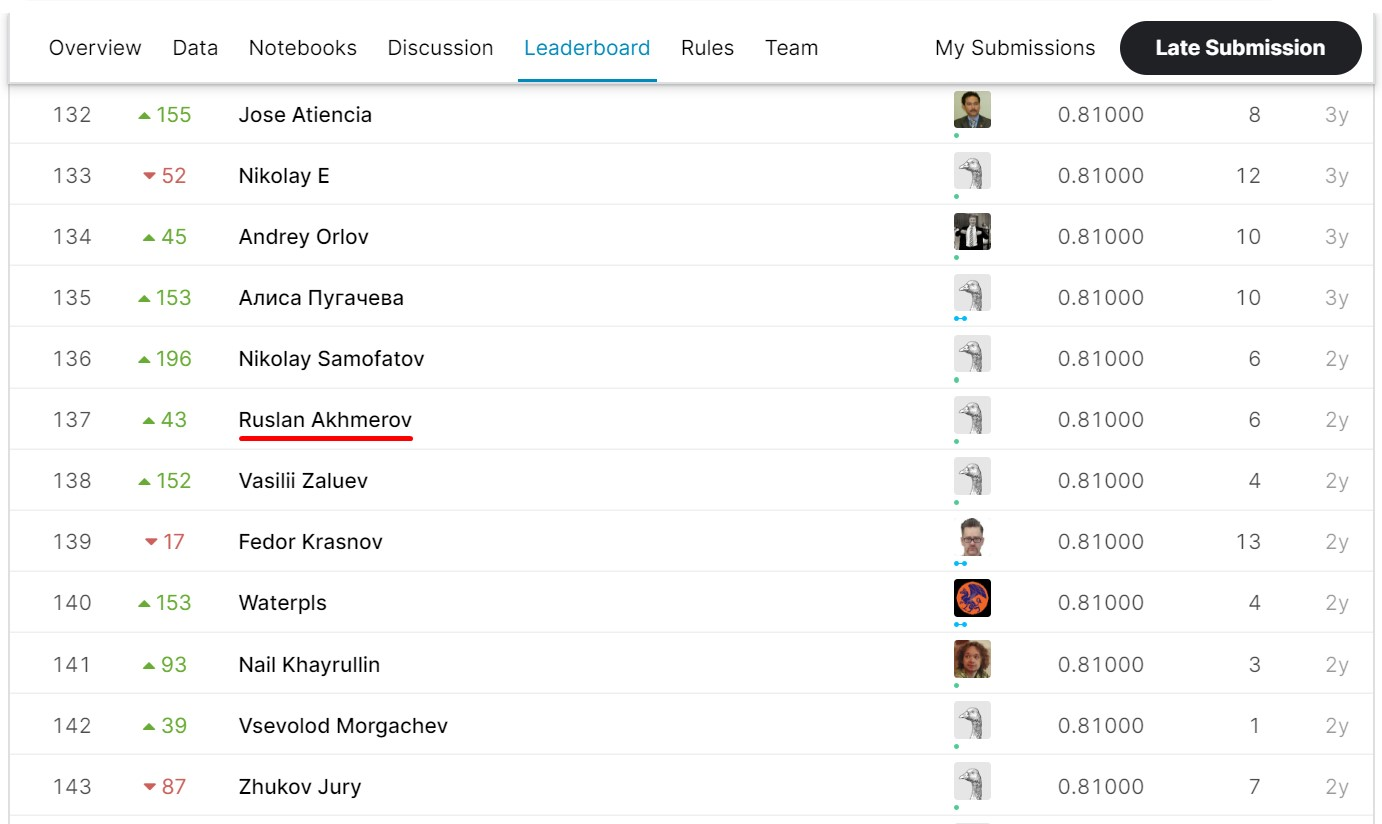